# Image Captioning

# Dataset

## Download [MS COCO](https://cocodataset.org/#download)
* train images: http://images.cocodataset.org/zips/train2014.zip
* val images: http://images.cocodataset.org/zips/val2014.zip
* captions for both train and validation: http://images.cocodataset.org/annotations/annotations_trainval2014.zip


In [1]:
import urllib
import zipfile
from tqdm import tqdm

BASE_PATH = 'data_dir'

# -- https://stackoverflow.com/a/53877507/1558946
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_data(url, extract_to=BASE_PATH):
    print(f"Downloading from {url}...")

    with DownloadProgressBar(unit='B', unit_scale=True, miniters=1, desc=url.split('/')[-1]) as t:
        zip_path, _ = urllib.request.urlretrieve(url, reporthook = t.update_to)

    print("Extracting files...")

    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        for file_name in tqdm(iterable=file_list, total=len(file_list), desc="Extracting files"):
            zip_ref.extract(member=file_name, path=extract_to)

    print(f"Files extracted to {extract_to}")

In [ ]:
download_data("http://images.cocodataset.org/annotations/annotations_trainval2014.zip")
download_data("http://images.cocodataset.org/zips/train2014.zip")
download_data("http://images.cocodataset.org/zips/val2014.zip")

## Vis.
* (ref) [Image Captioning on COCO Dataset](https://www.kaggle.com/code/pritishmishra/image-captioning-on-coco-dataset), kaggle.

In [2]:
import os
import re
import json
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# -- Load the annotations data from the JSON file
with open(f'{BASE_PATH}/annotations/captions_train2014.json', 'r') as f:
    data = json.load(f)['annotations']

# -- Create a list to hold image-caption pairs
img_cap_pairs = []

for sample in data:
    # Format the image name with leading zeros
    img_name = f'{sample["image_id"]:012d}.jpg'
    # Create the full image path
    img_path = f'{BASE_PATH}/train2014/COCO_train2014_{img_name}'
    # Append the image path and caption to the list
    img_cap_pairs.append([img_path, sample['caption']])

# -- Convert the list of pairs into a DataFrame
captions = pd.DataFrame(img_cap_pairs, columns=['image', 'caption'])

# -- Randomly sample 70,000 captions and reset the index
captions = captions.sample(70000).reset_index(drop=True)

# -- Display the first few rows of the DataFrame
captions.head()

,image,caption
0,data_dir/train2014/COCO_train2014_000000173422...,Baseball players are on the field with an empt...
1,data_dir/train2014/COCO_train2014_000000298836...,an image of a street sign in a residential set...
2,data_dir/train2014/COCO_train2014_000000000307...,A brown and white dog chasing a blue and yello...
3,data_dir/train2014/COCO_train2014_000000179860...,Many airport employees work around a plane on ...
4,data_dir/train2014/COCO_train2014_000000014359...,Three people pose together for a picture while...


In [4]:
def preprocess(text):
    """
    Preprocesses the input text by performing the following steps:
    1. Converts the text to lowercase.
    2. Removes any non-alphanumeric characters (excluding spaces).
    3. Replaces multiple spaces with a single space.
    4. Strips leading and trailing spaces.
    5. Adds '[start]' at the beginning and '[end]' at the end of the text.
    """
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove non-alphanumeric characters
    text = re.sub(r'\s+', ' ', text)     # Replace multiple spaces with a single space
    text = text.strip()                  # Strip leading and trailing spaces
    text = f'[start] {text} [end]'       # Add start and end tokens
    return text

# Apply the preprocess function to the 'caption' column
captions['caption'] = captions['caption'].apply(preprocess)

# Display the first few rows of the DataFrame
captions.head()

,image,caption
0,data_dir/train2014/COCO_train2014_000000173422...,[start] baseball players are on the field with...
1,data_dir/train2014/COCO_train2014_000000298836...,[start] an image of a street sign in a residen...
2,data_dir/train2014/COCO_train2014_000000000307...,[start] a brown and white dog chasing a blue a...
3,data_dir/train2014/COCO_train2014_000000179860...,[start] many airport employees work around a p...
4,data_dir/train2014/COCO_train2014_000000014359...,[start] three people pose together for a pictu...


[start] a red double decker bus parked outside of a building [end]


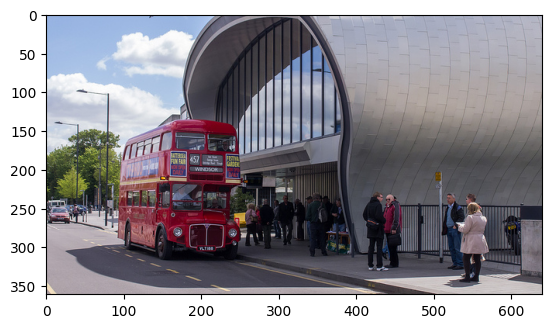

In [5]:
random_row = captions.sample(1).iloc[0]
print(random_row.caption)

im = Image.open(random_row.image)
plt.imshow(im)
plt.show()

# Preprocess

## Build Vocabulary

In [6]:
from collections import Counter
import pickle
from pycocotools.coco import COCO

In [7]:
# -- NLTK(Natural Language Toolkit) 라이브러리을 사용해 영어 문장을 토큰화.
import nltk
nltk.download('punkt')  # essential!
from nltk.tokenize import word_tokenize

text = "This is an example sentence."
tokens = word_tokenize(text)
print(tokens)

['This', 'is', 'an', 'example', 'sentence', '.']


[nltk_data] Downloading package punkt to /home/kist-cvipl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
class Vocab:
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.w2i = {}  # Word to index
        self.i2w = {}  # Index to word
        self.index = 0  # Current index

    def __call__(self, token):
        """Returns the index of the token or the index of '<unk>' if token not found."""
        return self.w2i.get(token, self.w2i['<unk>'])

    def __len__(self):
        """Returns the size of the vocabulary."""
        return len(self.w2i)

    def add_token(self, token):
        """Adds a token to the vocabulary."""
        if token not in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

    def add_special_tokens(self, tokens):
        """Adds special tokens to the vocabulary."""
        for token in tokens:
            self.add_token(token)

In [9]:
def build_vocabulary(json_file, threshold):
    """Builds a vocabulary from the COCO annotations file."""
    coco = COCO(json_file)
    counter = Counter()

    # Count the frequency of each token in the captions
    ids = coco.anns.keys()
    for i, ann_id in enumerate(ids):
        caption = str(coco.anns[ann_id]['caption']).lower()
        tokens = word_tokenize(caption)
        counter.update(tokens)

        if (i + 1) % 1000 == 0:
            print(f"[{i + 1}/{len(ids)}] Tokenized the captions.")

    # Filter out tokens below the frequency threshold
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]

    # Create a vocab instance and add special tokens
    vocab = Vocab()
    vocab.add_special_tokens(['<pad>', '<start>', '<end>', '<unk>'])

    # Add the frequent tokens to the vocabulary
    for token in tokens:
        vocab.add_token(token)

    return vocab

1. Vocabulary Class:
* __init__: 단어-인덱스와 인덱스-단어 사전을 초기화합니다.
* __call__: 주어진 토큰의 인덱스를 반환하거나, 토큰이 없을 경우 <unk>의 인덱스를 반환합니다.
* __len__: 어휘의 크기를 반환합니다.
* `add_token`: 주어진 토큰을 어휘에 추가합니다.

2. build_vocabulary 함수:

* 주어진 COCO 주석 파일을 사용하여 단어 빈도를 계산합니다.
* 단어 빈도가 임계값 이상인 단어들만 포함한 어휘를 만듭니다.
* `<pad>`, `<start>`, `<end>`, `<unk>`와 같은 특수 토큰을 추가합니다.

3. 어휘 구축 및 저장:

* `build_vocabulary` 함수를 사용해 어휘를 구축합니다.
* 구축된 어휘를 pickle을 사용해 파일로 저장합니다.

In [ ]:
# -- Build the vocabulary
vocab = build_vocabulary(json_file=f'{BASE_PATH}/annotations/captions_train2014.json', threshold=4)

# -- Save the vocabulary to a file
vocab_path = f'{BASE_PATH}/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)

print(f"Total vocabulary size: {len(vocab)}")
print(f"Saved the vocabulary wrapper to '{vocab_path}'")

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


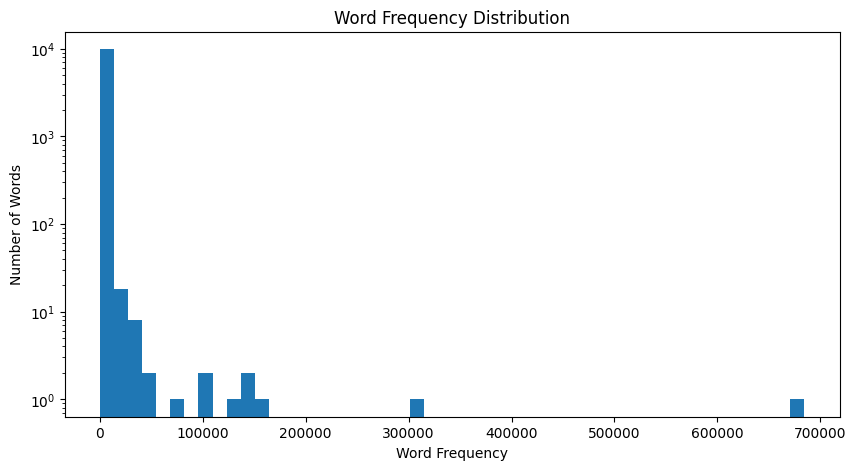

In [11]:
def visualize_word_frequency(json_file, threshold):
    """Visualizes the word frequency distribution from the COCO annotations file."""
    coco = COCO(json_file)
    counter = Counter()

    # Count the frequency of each token in the captions
    for i, ann_id in enumerate(coco.anns.keys()):
        caption = coco.anns[ann_id]['caption'].lower()
        tokens = nltk.tokenize.word_tokenize(caption)
        counter.update(tokens)

    # Filter out tokens below the frequency threshold
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
    token_counts = [cnt for token, cnt in counter.items() if cnt >= threshold]

    # Plot the frequency distribution
    plt.figure(figsize=(10, 5))
    plt.hist(token_counts, bins=50, log=True)
    plt.title('Word Frequency Distribution')
    plt.xlabel('Word Frequency')
    plt.ylabel('Number of Words')
    plt.show()

# Visualize word frequency distribution
visualize_word_frequency(json_file=f'{BASE_PATH}/annotations/captions_train2014.json', threshold=4)

## Resize images
* `Train Loop`의 Transformation 과정에서 (224,224)로 RandomCrop 하려면 이미지 width, height이 최소 224 보다는 커야 하므로 본 과정을 추가함.

In [12]:
def reshape_image(image, shape):
    """
    Resize an image to the given shape.

    Parameters:
        image (PIL.Image): The image to resize.
        shape (tuple): The desired shape (width, height).

    Returns:
        PIL.Image: The resized image.
        PIL.Image.ANTIALIAS = PIL.Image.LANCZOS for latest version.
    """
    return image.resize(shape, Image.LANCZOS)

def reshape_images(image_path, output_path, shape):
    """
    Reshape the images in 'image_path' and save them to 'output_path'.

    Parameters:
        image_path (str): The directory containing the images to resize.
        output_path (str): The directory to save the resized images.
        shape (tuple): The desired shape (width, height) for the resized images.
    """
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    images = os.listdir(image_path)

    for image_name in tqdm(images, desc="Resizing images"):
        image_file_path = os.path.join(image_path, image_name)

        with Image.open(image_file_path) as image:
            # Resize and save the image
            resized_image = reshape_image(image, shape)
            resized_image.save(os.path.join(output_path, image_name), image.format)

In [ ]:
# -- Define the paths and desired image shape
image_path = f'{BASE_PATH}/train2014/'
output_path = f'{BASE_PATH}/resized_images/'
image_shape = (256, 256)

# -- Reshape and save the images
reshape_images(image_path, output_path, image_shape)

# DataLoader

In [13]:
import torch

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

/home/kist-cvipl/anaconda3/envs/pt113/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
class CustomCocoDataset(Dataset):
    """COCO Custom Dataset compatible with torch.utils.data.DataLoader."""
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        """
        Args:
            data_path (str): Directory with all the images.
            coco_json_path (str): Path to the COCO annotation file.
            vocabulary (Vocab): Vocabulary wrapper.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform

    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        annotation_id = self.indices[idx]
        caption = self.coco_data.anns[annotation_id]['caption']
        image_id = self.coco_data.anns[annotation_id]['image_id']
        image_path = self.coco_data.loadImgs(image_id)[0]['file_name']

        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Convert caption (string) to word ids.
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption_ids = [self.vocabulary('<start>')] + [self.vocabulary(token) for token in word_tokens] + [self.vocabulary('<end>')]
        caption_tensor = torch.Tensor(caption_ids)
        return image, caption_tensor

    def __len__(self):
        return len(self.indices)

In [15]:
def collate_function(data_batch):
    """
    Creates mini-batch tensors from the list of tuples (image, caption).

    Args:
        data_batch (list of tuple): List of tuples where each tuple contains an image tensor and a caption tensor.
            - image: torch tensor of shape (3, 256, 256).
            - caption: torch tensor of shape (?); variable length.

    Returns:
        images (torch.Tensor): Tensor of shape (batch_size, 3, 256, 256).
        targets (torch.Tensor): Tensor of shape (batch_size, padded_length).
        lengths (list): List of valid lengths for each padded caption.
    """
    # Sort data_batch by caption length in descending order
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    images, captions = zip(*data_batch)

    # Stack images (from list of 3D tensors to 4D tensor)
    images = torch.stack(images, 0)

    # Merge captions (from list of 1D tensors to 2D tensor)
    caption_lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(caption_lengths)).long()
    for i, cap in enumerate(captions):
        end = caption_lengths[i]
        targets[i, :end] = cap[:end]

    return images, targets, caption_lengths


def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    """
    Returns torch.utils.data.DataLoader for custom COCO dataset.

    Args:
        data_path (str): Directory with all the images.
        coco_json_path (str): Path to the COCO annotation file.
        vocabulary (Vocab): Vocabulary wrapper.
        transform (callable): Optional transform to be applied on an image.
        batch_size (int): Number of samples per batch.
        shuffle (bool): Set to True to have the data reshuffled at every epoch.
        num_workers (int): Number of subprocesses to use for data loading.

    Returns:
        DataLoader: DataLoader for the custom COCO dataset.
    """
    coco_dataset = CustomCocoDataset(data_path=data_path,
                                     coco_json_path=coco_json_path,
                                     vocabulary=vocabulary,
                                     transform=transform)

    return DataLoader(dataset=coco_dataset,
                      batch_size=batch_size,
                      shuffle=shuffle,
                      num_workers=num_workers,
                      collate_fn=collate_function)

## dataloader test

In [17]:
# -- 데이터 로더 생성
data_path = f'{BASE_PATH}/resized_images'
coco_json_path = f'{BASE_PATH}/annotations/captions_train2014.json'

# Load vocabulary wrapper
with open(f'{BASE_PATH}/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([
    transforms.RandomCrop(224),
    transforms.ToTensor()
    ])


data_loader = get_loader(data_path, coco_json_path, vocabulary,
                         transform, batch_size=4, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.58s)
creating index...
index created!


In [18]:
# 데이터 로더 테스트
for i, (images, captions, lengths) in enumerate(data_loader):
    print(f"Batch {i + 1}")
    print("Images shape:", images.shape)
    print("Captions shape:", captions.shape) # (batch_size, caption_lengths)
    print("Lengths:", lengths) # 캡션에서 (패딩 빼고) 실제 단어의 개수를 나타내는 리스트
    if i == 1:  # 두 배치만 확인하고 종료
        break

Batch 1
Images shape: torch.Size([4, 3, 224, 224])
Captions shape: torch.Size([4, 16])
Lengths: [16, 12, 10, 9]
Batch 2
Images shape: torch.Size([4, 3, 224, 224])
Captions shape: torch.Size([4, 13])
Lengths: [13, 13, 12, 12]


## Vis.

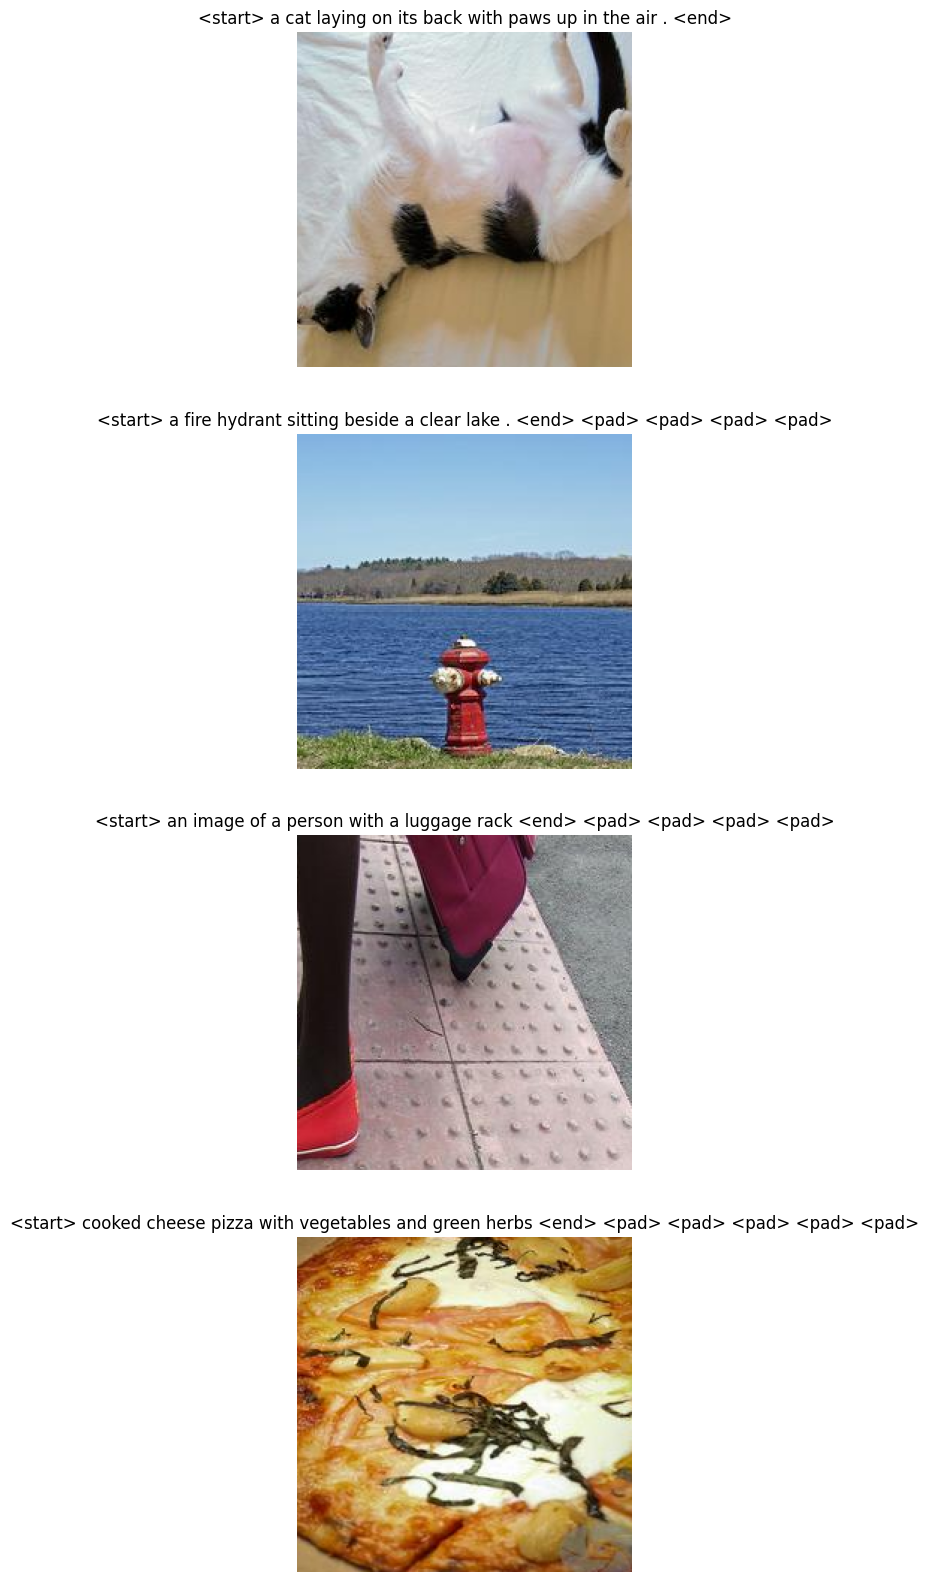

In [19]:
batch_instance = next(iter(data_loader))
images, captions, lengths = batch_instance

fig, axes = plt.subplots(len(images), 1, figsize=(5, 20))

for i in range(len(images)):
    image = images[i].permute(1, 2, 0)  # 채널 차원을 마지막으로 이동
    caption = captions[i]
    caption_text = ' '.join([vocabulary.i2w[idx.item()] for idx in caption if idx.item() in vocabulary.i2w])

    axes[i].imshow(image)
    axes[i].set_title(caption_text, fontsize=12)
    axes[i].axis('off')
plt.show()

# Model

In [20]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

import torchvision.models as models

An image-to-caption model that can produce descriptions for real world image.

<div style="text-align: center;">
    <img src="https://3.bp.blogspot.com/-QfV7QzVq61Y/VGp6hTrMblI/AAAAAAAAAcY/qk3eCwbtpVs/s1600/image01.png" alt="Beautiful Scenery" width="600"/>
    <p>Model architecture: CNN encoder and RNN decoder</p>
</div>

* [img src](https://research.google/blog/a-picture-is-worth-a-thousand-coherent-words-building-a-natural-description-of-images/)
* [Show and Tell: A Neural Image Caption Generator](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Vinyals_Show_and_Tell_2015_CVPR_paper.html), Vinyals, O., et al., 2015.


## Image Encoder

In [21]:
class CNN(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace the top fc layer."""
        super(CNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        module_list = list(resnet.children())[:-1]  # Remove the last fc layer
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)

    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)

        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features

In [22]:
# -- Test
encoder_model = CNN(embedding_size=256)
encoder_model.eval()
dummy_input = torch.randn(1, 3, 224, 224)

output = encoder_model(dummy_input)
print(output.shape)

/home/kist-cvipl/anaconda3/envs/pt113/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kist-cvipl/anaconda3/envs/pt113/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([1, 256])


## Text Decoder

In [23]:
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len

    def forward(self, input_features, caps, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        packed_embeddings = pack_padded_sequence(embeddings, lens, batch_first=True, enforce_sorted=True)
        hidden_variables, _ = self.lstm_layer(packed_embeddings)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs

    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for _ in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states) # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                               # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs).unsqueeze(1)        # (batch_size, embed_size) -> (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                             # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

In [24]:
# -- Test
embedding_size = 256      # 단어 임베딩 벡터의 크기
hidden_layer_size = 512   # LSTM의 hidden state 크기
vocabulary_size = 10000   # 단어 집합의 크기
num_layers = 1            # LSTM 레이어의 개수
max_seq_len = 20          # 최대 시퀀스 길이

decoder_model = LSTMModel(embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len)
decoder_model.eval()  # Set the model to evaluation mode


# -- dummy input
batch_size = 4
input_features = torch.randn(batch_size, embedding_size)
caps = torch.randint(0, vocabulary_size, (batch_size, max_seq_len))
lens = torch.tensor([max_seq_len] * batch_size)  # Assume all sequences have the same length for simplicity

# -- inference
outputs = decoder_model(input_features, caps, lens)
print("Forward pass output shape:", outputs.shape)  # (batch_size x seq_len , vocab_size)

sampled_captions = decoder_model.sample(input_features)
print("Sampled captions shape:", sampled_captions.shape) # (batch_size, num_token_ID)

Forward pass output shape: torch.Size([80, 10000])
Sampled captions shape: torch.Size([4, 20])


# Train Loop

## dataloader

In [25]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory if it doesn't exist
model_dir = 'models_dir/'
os.makedirs(model_dir, exist_ok=True)


# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Build data loader
data_loader = get_loader(data_path, coco_json_path, vocabulary, transform,
                         batch_size=128, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=0.55s)
creating index...
index created!


## model

In [26]:
# Build the models
encoder_model = CNN(256).to(device)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device)

## loss & opt.

In [27]:
# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())

optimizer = torch.optim.Adam(parameters, lr=0.001)

## train start

In [ ]:
# Train the models
num_epochs = 5
log_step = 10
save_step = 1000

for epoch in range(num_epochs):
    for i, (images, captions, lengths) in enumerate(data_loader):
        # Set mini-batch dataset
        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        # Forward pass
        features = encoder_model(images)
        outputs = decoder_model(features, captions, lengths)
        loss = loss_criterion(outputs, targets)

        # Backward and optimize
        encoder_model.zero_grad()
        decoder_model.zero_grad()
        loss.backward()
        optimizer.step()

        # Print log info
        if i % log_step == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(data_loader)}], Loss: {loss.item():.4f}, Perplexity: {np.exp(loss.item()):5.4f}')

        # Save the model checkpoints
        if (i + 1) % save_step == 0:
            torch.save(decoder_model.state_dict(), os.path.join(model_dir, f'decoder-{epoch+1}-{i+1}.ckpt'))
            torch.save(encoder_model.state_dict(), os.path.join(model_dir, f'encoder-{epoch+1}-{i+1}.ckpt'))

# Inference

## Prepare image
img_sources: https://stock.adobe.com/

In [29]:
!wget -O cow_in_field.png https://as1.ftcdn.net/v2/jpg/08/39/13/68/1000_F_839136814_gbCX7ckkHNNmfpsnUwBSsznP7oO4rGkm.jpg

--2024-07-10 15:10:08--  https://as1.ftcdn.net/v2/jpg/08/39/13/68/1000_F_839136814_gbCX7ckkHNNmfpsnUwBSsznP7oO4rGkm.jpg
Resolving as1.ftcdn.net (as1.ftcdn.net)... 151.101.1.167, 151.101.65.167, 151.101.129.167, ...
Connecting to as1.ftcdn.net (as1.ftcdn.net)|151.101.1.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 393997 (385K) [image/jpeg]
Saving to: ‘cow_in_field.png’

cow_in_field.png    100%[===================>] 384.76K  --.-KB/s    in 0.03s   

2024-07-10 15:10:08 (13.6 MB/s) - ‘cow_in_field.png’ saved [393997/393997]



In [30]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406),
                         (0.229, 0.224, 0.225))])

In [31]:
def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)

    if transform is not None:
        img = transform(img).unsqueeze(0)

    return img

img_path = 'cow_in_field.png'

# Prepare an image
img = load_image(img_path, transform)
img_tensor = img.to(device)

## Load model

In [32]:
# -- Load vocabulary wrapper
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# -- Build models
encoder_model = CNN(256).to(device).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(256, 512, len(vocabulary), 1).to(device).eval()

# -- Load the trained model parameters
encoder_model.load_state_dict(torch.load('models_dir/encoder-1-3000.ckpt'))
decoder_model.load_state_dict(torch.load('models_dir/decoder-1-3000.ckpt'))

<All keys matched successfully>

## Generate an caption from the image

In [33]:
# -- Generate an caption from the image
feat = encoder_model(img_tensor)              # Extract features from the image
sampled_indices = decoder_model.sample(feat)  # Generate sampled indices
sampled_indices = sampled_indices[0].cpu().numpy()  # (1, max_seq_length) -> (max_seq_length)

# -- Convert token_ids to words
predicted_caption = []

for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break

# -- Join words to form the predicted sentence
predicted_sentence = ' '.join(predicted_caption)

## Vis.

<start> a herd of cattle standing on top of a lush green field . <end>


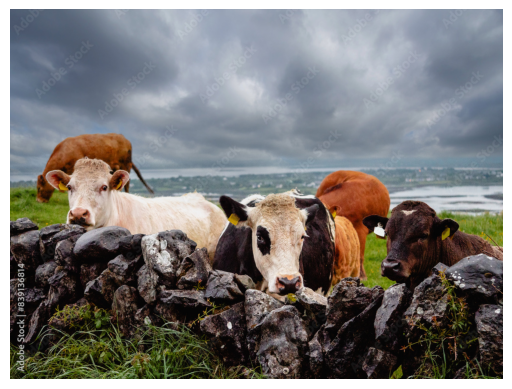

In [34]:
print(predicted_sentence)

img = Image.open(img_path)
plt.imshow(np.asarray(img))
plt.axis('off')  # Hide axes
plt.show()

# Reference
* [A picture is worth a thousand (coherent) words: building a natural description of images](https://research.google/blog/a-picture-is-worth-a-thousand-coherent-words-building-a-natural-description-of-images/), Google Research, 2014.
* [coco-caption/cocoEvalCapDemo.ipynb](https://github.com/tylin/coco-caption/blob/master/cocoEvalCapDemo.ipynb)
